In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = (pd.read_json("data/sweep.jsonl", lines=True)
      .pipe(lambda d: d.assign(rougeL_stderr=d.results.map(lambda r: np.std([x["rougeL"] for x in r]) / (len(r) ** 0.5))))
      .drop(columns="results")
      .to_json("summary.json"))

In [4]:
df = pd.read_json("summary.json")

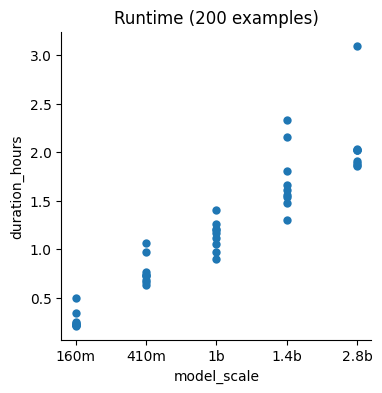

In [7]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df.pipe(lambda d: d.assign(duration_hours=d._duration/3600)), x="model_scale", y="duration_hours", linewidth=0)
plt.title("Runtime (200 examples)")
sns.despine();

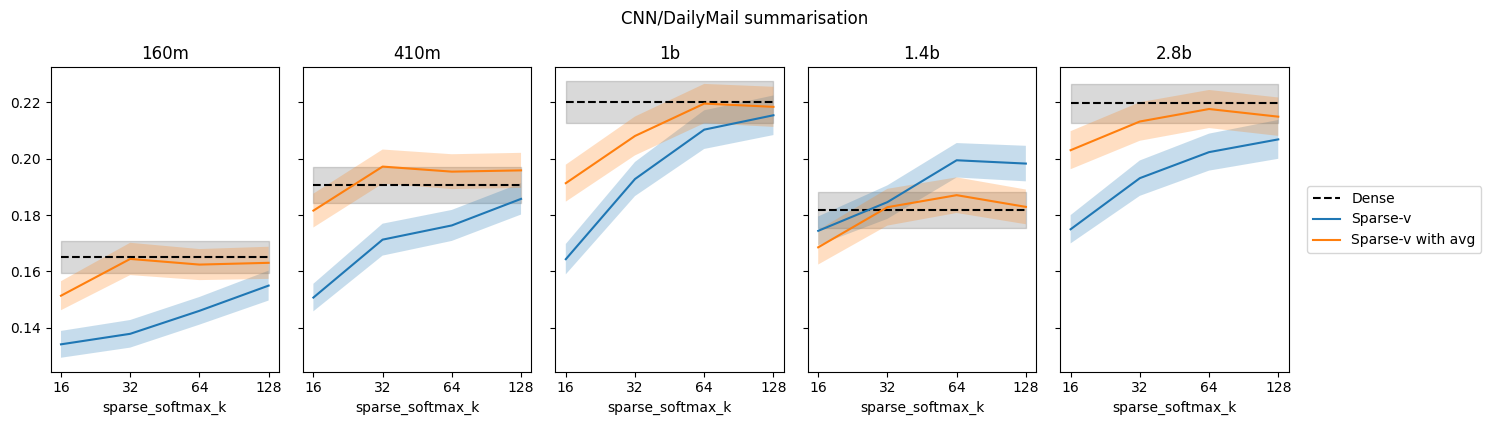

In [6]:
confidence = 1.0

g = df.fillna(dict(sparse_softmax_avg=False)).groupby("model_scale", sort=False)
_, axs = plt.subplots(1, len(g), figsize=(3*len(g), 4), sharey=True)
for (model_scale, d), ax in zip(g, axs):
    dense = d[d.sparse_softmax_k.isna()]
    ax.hlines(dense.rougeL.iloc[0], 16, 128, "k", linestyle="dashed", label="Dense")
    ax.fill_between([16, 128], dense.rougeL - confidence * dense.rougeL_stderr, dense.rougeL + confidence * dense.rougeL_stderr, color="k", alpha=0.15)
    for avg, dd in d.sort_values("sparse_softmax_k").groupby("sparse_softmax_avg"):
        dd.plot(y="rougeL", x="sparse_softmax_k", ax=ax, label="Sparse-v with avg" if avg else "Sparse-v")
        ax.fill_between(dd.sparse_softmax_k, dd.rougeL - confidence * dd.rougeL_stderr, dd.rougeL + confidence * dd.rougeL_stderr, alpha=0.25)
    ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_title(model_scale)
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.suptitle("CNN/DailyMail summarisation", y=1.05);